# Project Motives
This project uses unsupervised learning algorithm KMeans and LDA to perform text clustering on 238 movie plots.    
Movies will be seperated into different clusters/topics with top 5 their keywords.    
This is useful for movie recommendation system. 

## Step 1: Dataset Description and  Data Preparation

**Dataset Description**   
We web crawled the IMDB website and extract these following info:  
Moive ID: Movie's unique ID on that site. It can be used to crawl all other information of that movie  
Raking: Their ranking in the top rated 250 movies   
Moive Name: Movie's English name and its production year   
Movie Plot: Movies' story, summary

**Data Preparation**

In [1]:
import pandas as pd
from urllib.request import urlopen 
from bs4 import BeautifulSoup
import re
import warnings
warnings.filterwarnings('ignore')
import numpy as np
import nltk
import os

Connect with IMDB top rated 250 movies and get their raw movie Ids, movie names and their production years.

In [2]:
html = urlopen("http://www.imdb.com/chart/top") 
bsObj = BeautifulSoup(html.read(),'html.parser')
movieEntries = bsObj .findAll('div', {'class':'wlb_ribbon'})
movieNames = bsObj.findAll('a', {'href':re.compile("/title/tt[0-9]{7}/")})
years = bsObj.findAll('span', {'class':"secondaryInfo"})

Concatenate movie names and thier production years

In [3]:
completeNames = []
for i in range(250):
    completeName = movieNames[(2 * i) + 1].get_text() + years[i].get_text()
    completeNames.append(completeName)

# Inspect 
completeNames[:5]

['The Shawshank Redemption(1994)',
 'The Godfather(1972)',
 'The Godfather: Part II(1974)',
 'The Dark Knight(2008)',
 '12 Angry Men(1957)']

Retrieve movie IDs for movie plots crawling on another page of the IMDB site

In [4]:
movieIds=[]
for entry in movieEntries:
    movieIds.append(entry['data-tconst'])

# Inspect
movieIds[:5]

['tt0111161', 'tt0068646', 'tt0071562', 'tt0468569', 'tt0050083']

In [5]:
# Define a function to use movie ID to crawl movie plot on other IMDB pages
def getPlot(movieId):
    html = urlopen('http://www.imdb.com/title/' + movieId + '/plotsummary')
    bsobj = BeautifulSoup(html.read(),'html.parser').find('li', {'id':re.compile("synopsis-py*")})
    if bsobj == None:
        return movieId
    else:
        return bsobj.get_text()

Retrieve movie plots 

In [6]:
moviePlots = []
for movieId in movieIds:
    plot = getPlot(movieId)
    moviePlots.append(plot)

In [7]:
# Inspect 
moviePlots[0]

'In 1947, Andy Dufresne (Tim Robbins), a banker in Maine, is convicted of murdering his wife and her lover, a golf pro. Since the state of Maine has no death penalty, he is given two consecutive life sentences and sent to the notoriously harsh Shawshank Prison. Andy always claims his innocence, but his cold and measured demeanor led many to doubt his word.During the first night, the chief guard, Byron Hadley (Clancy Brown), savagely beats an overweight and newly arrived inmate because of his crying and hysterics. The inmate later dies in the infirmary because the prison doctor had left for the night. Meanwhile, Andy remained steadfast and composed. Ellis Boyd Redding (Morgan Freeman), known as Red, bet against others that Andy would be the one to break down first and loses a considerable amount of cash. Red has been in prison for several years having been given three consecutive life sentences for the murder of his wife and two others.About a month later, Andy approaches Red, who runs 

Build a datafram which has movie ID, movie ranking, movie name and movie plot as its columns

In [8]:
df = pd.DataFrame(movieIds, columns = ['MovieId'])

In [9]:
df['Ranking'] = range(1,251)
df['MovieName'] = completeNames
df['MoviePlot'] = moviePlots

There are 11 movies that have no plots available on the IMDB site

In [10]:
df[df.MovieId == df.MoviePlot]

,MovieId,Ranking,MovieName,MoviePlot
37,tt0027977,38,Modern Times(1936),tt0027977
38,tt2380307,39,Coco(2017),tt2380307
99,tt0012349,100,The Kid(1921),tt0012349
115,tt0476735,116,Babam ve Oglum(2005),tt0476735
128,tt0044741,129,Ikiru(1952),tt0044741
168,tt0116231,169,The Bandit(1996),tt0116231
171,tt0091251,172,Come and See(1985),tt0091251
185,tt3011894,186,Relatos salvajes(2014),tt3011894
199,tt0053198,200,The 400 Blows(1959),tt0053198
211,tt0087544,212,Nausicaä of the Valley of the Wind(1984),tt0087544


So, we filter out above movies and create a new dataframe

In [11]:
df2 = df[df.MovieId != df.MoviePlot]

## Step 2: Tokenizing and Stemming

**What is tokenizing?**  
In layman's terms, it means break long document(aka. movie plots) into single words

** What is stemming?**   
Also in layman's terms, it means transform words back to their 'root' states.    
For example, unstemmed  word 'likes' -> stemmed word 'like'.

**Why do we need tokenizing and stemming?**  
Useful unigrams is the key of text clustering.   
These two steps are considered as the necessary steps for data preparation.

** How do we make use of tokenizing and stemming? **
1. We define a function called tokenize_and_stem to prepare data for the TF-IDF model.    
    This function will be set as a parameter for the TF-IDF model.
2. We also build a dict that has structure {unstemmed_word: stemmed_word}   
    When we anaylze the clustering and topic modeling, we can use this dict to show the actual words

** Get started **
<li> Load stopwords and stemmer function from NLTK library.  
<li> Stop words are words like "a", "the", or "in" which don't convey significant meaning.  

In [12]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Meiyuan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [13]:
# Use nltk's English stopwords.
stopwords = nltk.corpus.stopwords.words('english')

In [14]:
# We use this many stopwords
len(stopwords)

153

In [15]:
# Inspect
stopwords[:10]

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', 'your']

Here we define a function 'tokenize' to transform words in the movie plots   
e.g. 'He loves python' will be tokenized to ['he', 'loves','python']

In [16]:
# Use this function to tokenize each plot 
def tokenize(plot):
    # Break one movie plot into words, numbers and punctuations
    tokens=[]
    for word in nltk.word_tokenize(plot): 
        if word not in stopwords:
            tokens.append(word)  
    
    # filter out any tokens not containing letters (numbers and punctuations)
    filteredTokens = []
    for token in tokens:
        if re.match('^[a-zA-Z][a-zA-Z]*[a-zA-Z]$', token):
            filteredTokens.append(token)
    return filteredTokens

<li> Stemming is the process of breaking a word down into its root.
<li> ['He', 'loves','python'] will be transformed to ['he', 'love','python']

Here we define a function to tokenize and stem words in the movie plots

In [17]:
# Use this function to stem the previous tokenized words
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")

def tokenize_and_stem(plot):
    # Call tokenize function first
    filteredTokens = tokenize(plot)
    
    # Stem the filtered tokens
    stemedTokens = []
    for filteredTD in filteredTokens:
        stemedTokens.append(stemmer.stem(filteredTD))
    return stemedTokens

Use our defined functions to transform 238 movie plots into 2 giant lists of words

In [18]:
nltk.download('punkt')
all_words_tokenized = []
all_words_stemmed = []
for plot in df2.MoviePlot:
    tokenized_Results = tokenize(plot)
    all_words_tokenized.extend(tokenized_Results)
    
    tokenized_stemmed_Results = tokenize_and_stem(plot)
    all_words_stemmed.extend(tokenized_stemmed_Results )

[nltk_data] Downloading package punkt to /Users/Meiyuan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [19]:
# Inspect
all_words_tokenized[:5]

['In', 'Andy', 'Dufresne', 'Tim', 'Robbins']

In [20]:
# Inspect
all_words_stemmed[:5]

['in', 'andi', 'dufresn', 'tim', 'robbin']

Zip these two into a dict for Kmeans and Topic Modeling results analysis use

In [21]:
stemmed_unstemmed_dict = dict(zip(all_words_stemmed,all_words_tokenized))

In [22]:
# Inspect
stemmed_unstemmed_dict

{'in': 'In',
 'andi': 'Andy',
 'dufresn': 'Dufresne',
 'tim': 'Tim',
 'robbin': 'Robbins',
 'banker': 'banker',
 'main': 'main',
 'convict': 'convict',
 'murder': 'murder',
 'wife': 'wife',
 'lover': 'lover',
 'golf': 'golf',
 'pro': 'pro',
 'sinc': 'since',
 'state': 'state',
 'death': 'death',
 'penalti': 'penalty',
 'given': 'given',
 'two': 'two',
 'consecut': 'consecutive',
 'life': 'life',
 'sentenc': 'sentences',
 'sent': 'sent',
 'notori': 'notorious',
 'harsh': 'harshly',
 'shawshank': 'Shawshank',
 'prison': 'prisoner',
 'alway': 'always',
 'claim': 'claiming',
 'innoc': 'innocently',
 'cold': 'Cold',
 'measur': 'measures',
 'demeanor': 'demeanor',
 'led': 'led',
 'mani': 'many',
 'doubt': 'doubts',
 'first': 'First',
 'night': 'night',
 'chief': 'Chief',
 'guard': 'guard',
 'byron': 'Byron',
 'hadley': 'Hadley',
 'clanci': 'Clancy',
 'brown': 'Brown',
 'savag': 'Savage',
 'beat': 'beats',
 'overweight': 'overweight',
 'newli': 'newly',
 'arriv': 'arrives',
 'inmat': 'inmate'

## Step 3: TF-IDF (Term Frequency - Inverse Document Frequency)

**What is TF-IDF?**   

It's a weight, a statistical measure used to evaluate how important a word is to a document in a collection or corpus.    
The importance increases proportionally to the number of times a word appears in the document but is offset by the frequency of the word in the corpus.    

<li> TF: Term Frequency, which measures how frequently a term occurs in a document.   
Since every document is different in length, it is possible that a term would appear much more times in long documents than shorter ones.    
Thus, the term frequency is often divided by the document length (aka. the total number of terms in the document) as a way of normalization: 

TF(t) = (Number of times term t appears in a document) / (Total number of terms in the document).

<li> IDF: Inverse Document Frequency, which measures how important a term is.    
While computing TF, all terms are considered equally important. However it is known that certain terms, such as "is", "of", and "that", may appear a lot of times but have little importance. Thus we need to weigh down the frequent terms while scale up the rare ones, by computing the following: 

IDF(t) = log_e(Total number of documents / Number of documents with term t in it).

<li> Then we do this TF(t)  * IDF(t)

Example:

1. A document containing **100 words** wherein the word **cat** appears **3 times**.  
    The term frequency (i.e., tf) for cat is then (3 / 100) = **0.03**
3. Assume we have **10 million documents** and the word cat appears in **1000** of these.   
   The inverse document frequency (i.e., idf) is calculated as log(10,000,000 / 1,000) = **4** 
5. The Tf-idf weight is the product of these quantities:   0.03 * 4 = 0.12

**How do we make use of TF-IDF?**   
<li> To run KMeans, we need to fit a matrix to the KMeans model.   
<li> Numbers in this matrix should be the tf-idf weight for each word.   
<li> sklearn.feature_extraction.text.TfidfVectorizer will provide us that matrix through these following steps.   

**Parameters for the model**
<li> max_df: maximum frequency within the plots a given word can have to be used in the tfi-idf matrix.  
If the word is in greater than 80% of the plots it probably cares little meanining (in the context of movie plots)
<li> min_df: the word must be in at least 20% of the plots.   
If a lower min_df is allowed, clustering results will be based on names--for example "Michael" or "Tom" are names found in several of the movies and the plots use these names frequently, but these names carry no real meaning.
<li> ngram_range: we only run analysis on unigram
<li> tokenizer: we use our own function 'tokenize_and_stem' to process words

In [23]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Build the model and set parameters
tfidfModel = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=0.2, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,1))

In [24]:
# Fit the movie plots to model
# It will learn words and idf from input and return a document-term matrix.
tfidfMatrix = tfidfModel.fit_transform(df2.MoviePlot) 

In [25]:
# This matrix has 238 movies(Docs) and 510 words(terms)
tfidfMatrix.shape

(238, 510)

In [26]:
tfidfMatrix.toarray()

array([[ 0.        ,  0.03947226,  0.        , ...,  0.07729889,
         0.        ,  0.01729865],
       [ 0.        ,  0.        ,  0.0401982 , ...,  0.07075319,
         0.        ,  0.06333516],
       [ 0.        ,  0.        ,  0.02478961, ...,  0.05235887,
         0.        ,  0.03905781],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.18352899],
       [ 0.05951702,  0.04837972,  0.05382762, ...,  0.11369093,
         0.        ,  0.04240464],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

Save the words/terms/features identified by TF-IDF.

In [27]:
all_words_from_tfidf = tfidfModel.get_feature_names()

In [28]:
# Inspect
all_words_from_tfidf[:5]

['abandon', 'abl', 'accept', 'accompani', 'act']

## Step 4: KMeans clustering

In [29]:
from sklearn.cluster import KMeans

# Set how many clusters we want
num_of_clusters = 3

# Build the model
clusters = KMeans(n_clusters=num_of_clusters,random_state=0)

# Fit the model with tfidfMatrix
clusters.fit(tfidfMatrix)

# Get movie clusters
cluster_IDs = clusters.labels_.tolist()

### 4.1. Analyze KMeans Result

In [30]:
# Add cluster info to the original dataframe
df2['cluster'] = cluster_IDs

In [31]:
df2.index = df2.cluster

In [32]:
df2[:5]

,MovieId,Ranking,MovieName,MoviePlot,cluster
cluster,,,,,
1,tt0111161,1,The Shawshank Redemption(1994),"In 1947, Andy Dufresne (Tim Robbins), a banker...",1
1,tt0068646,2,The Godfather(1972),"In late summer 1945, guests are gathered for t...",1
1,tt0071562,3,The Godfather: Part II(1974),The Godfather Part II presents two parallel st...,1
2,tt0468569,4,The Dark Knight(2008),The movie begins with a gang of men with clown...,2
1,tt0050083,5,12 Angry Men(1957),"In a New York City courthouse, an eighteen-yea...",1


Number of movies included in each cluster:

In [33]:
df2['cluster'].value_counts().to_frame()

,cluster
1,95
2,81
0,62


<li> clusters.cluster_centers returns a 10 * 510 2d array  
<li> 10 means 10 clusters and 510 means 510 terms/words/features

In [34]:
clusters.cluster_centers_.shape

(3, 510)

<li> Every number in this 2d array denotes the importance of each word/term in that cluster  
<li> Higher number means more important and closer to the centroid

In [35]:
clusters.cluster_centers_

array([[ 0.01676157,  0.02520873,  0.01158583, ...,  0.02116565,
         0.00757549,  0.02165491],
       [ 0.01377229,  0.01529343,  0.01714999, ...,  0.04687114,
         0.00680806,  0.03418755],
       [ 0.01054626,  0.01622341,  0.01511123, ...,  0.02772457,
         0.01493418,  0.03231202]])

How would we interprete this 2d array and help us understand the clustering result?

 Take cluster 0 as example, the most important word will be the one has this value

In [36]:
clusters.cluster_centers_[0].max()

0.095325432619277214

But to get the actual word, we need to know the index of the word

In [37]:
clusters.cluster_centers_[0].argmax()

417

Use this index to get the acutal word

In [38]:
all_words_from_tfidf[165]

'far'

Use stemmed_unstemmed_dict to get the unstemmed version of the word

In [39]:
stemmed_unstemmed_dict['father']

'father'

<li> So if we want to extract the 5 most important words/terms/features from each cluster  
<li> We retrieve the indices of these words
<li> Instead of argmax, we use argsort to get the indices that would sort the array  
<li> However, argsort is sorted in an ascedning order  
<li> So indices of the 5 most important words(which have higher number) are located in the last 5 places of the array

Again, take cluster 0 as an example

In [40]:
orderedCentroids = clusters.cluster_centers_.argsort() 

In [41]:
# Step 1 
# [0,:-6:-1] extract the max 5 values' indices of cluster 0
orderedCentroids[0,:-6:-1]

array([417, 240, 152, 483, 402])

In [42]:
# Step 2
# Use all_words_from_tfidf to get the actual words  
# This word is stemmed
all_words_from_tfidf[165]

'far'

In [43]:
# Step 3
# Use stemmed_unstemmed_dict to get the unstemmed version of the word
stemmed_unstemmed_dict['father']

'father'

In [44]:
# Base on above three steps, we define this function to extract keywords
def print_cluster_keywords(cluster_ID):   
    print ("Cluster " + str(cluster_ID)  + " top 5 keywords: " , end="")   
    
    cluster_keywords_dict[cluster_ID] = []
    top5_keywords_index = orderedCentroids[cluster_ID, :-6:-1] # step 1
    for index in top5_keywords_index:     
        stemmed_word = all_words_from_tfidf[index] # step 2
        unstemmed_word = stemmed_unstemmed_dict[stemmed_word] # step 3
        cluster_keywords_dict[cluster_ID].append(unstemmed_word)
    print (", ".join(cluster_keywords_dict[cluster_ID]))   

In [45]:
# Retrieve movies names by cluster Id
def print_cluster_movies(cluster_ID):
    moives_in_cluster = df2.loc[cluster_ID]['MovieName'].values.tolist()
    print ("Cluster " + str(cluster_ID) + " has " + str(len(moives_in_cluster)) + " movies: ") 
    print (", ".join(moives_in_cluster))
    print ()

**Print out cluster info**

In [46]:
print ("<Movie Plots Clustering Result by KMeans>")

cluster_keywords_dict = {} # Put clusters and their top 5 unstemmed words into one dict
for cluster_ID in range(num_of_clusters):
    print_cluster_keywords(cluster_ID)
    print_cluster_movies(cluster_ID)   

<Movie Plots Clustering Result by KMeans>
Cluster 0 top 5 keywords: soldiers, kill, escaped, War, ship
Cluster 0 has 62 movies: 
Schindler's List(1993), The Lord of the Rings: The Return of the King(2003), The Good, the Bad and the Ugly(1966), The Lord of the Rings: The Fellowship of the Ring(2001), Star Wars: Episode V - The Empire Strikes Back(1980), The Lord of the Rings: The Two Towers(2002), One Flew Over the Cuckoo's Nest(1975), Seven Samurai(1954), Star Wars: Episode IV - A New Hope(1977), The Silence of the Lambs(1991), Saving Private Ryan(1998), The Green Mile(1999), Casablanca(1942), Raiders of the Lost Ark(1981), Terminator 2(1991), Apocalypse Now(1979), Alien(1979), The Great Dictator(1940), Dr. Strangelove or: How I Learned to Stop Worrying and Love the Bomb(1964), Paths of Glory(1957), WALL·E(2008), Blade Runner 2049(2017), Aliens(1986), Das Boot(1981), Star Wars: Episode VI - Return of the Jedi(1983), Lawrence of Arabia(1962), Full Metal Jacket(1987), Inglourious Basterd

### 4.2. Validation - Plot KMeans Result

** What is PCA?**   
PCA is principal component analysis.   
In layman's terms, it reduces higher dimensions to a lower dimension.   
A 238 * 510 matrix is impossible to plot, so we reduce it to 2 dimensions.   
After PCA, each movie will have two components available for use.

In [47]:
from sklearn import decomposition

# Build the model
pca = decomposition.PCA(n_components=2)

# pca does not accept sparse matrix
# so, we transform the tfidfMatrix object to an array
tfidfMatrixArray = tfidfMatrix.toarray()

In [48]:
# Inspect
tfidfMatrixArray

array([[ 0.        ,  0.03947226,  0.        , ...,  0.07729889,
         0.        ,  0.01729865],
       [ 0.        ,  0.        ,  0.0401982 , ...,  0.07075319,
         0.        ,  0.06333516],
       [ 0.        ,  0.        ,  0.02478961, ...,  0.05235887,
         0.        ,  0.03905781],
       ..., 
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.18352899],
       [ 0.05951702,  0.04837972,  0.05382762, ...,  0.11369093,
         0.        ,  0.04240464],
       [ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ]])

In [49]:
# Fit the model 
pca.fit(tfidfMatrixArray)

# Apply dimensionality reduction to it
X = pca.transform(tfidfMatrixArray)

After dimensionality reduction, every plot/document will have two numbers  
Instead of the 510 features/words/terms, now each plot is represented by 2 numbers(components)

In [50]:
X.shape

(238, 2)

This following line means after dimensionality reduction  
Movie 1 'The Shawshank Redemption(1994)' has  these two components with those values

In [51]:
X[0]

array([-0.02528112,  0.01870743])

Extract the two components' values to 2 lists

In [52]:
# First components' values in a list
xCoordinate = X[:, 0]
# Second components' values in a list
yCoordinate = X[:, 1]

In [53]:
# Inspect, first five movie's First Component's values after PCA
xCoordinate[:5]

array([-0.02528112, -0.05271232, -0.08137742,  0.14855685, -0.0155926 ])

In [54]:
# Inspect, first five movie's Second Component's values after PCA
yCoordinate[:5]

array([ 0.01870743, -0.03964529, -0.08723515,  0.22846966, -0.08702718])

In [55]:
# Create a data frame with PCA cluster results
PCA = pd.DataFrame(dict(xCoordinate=xCoordinate, yCoordinate=yCoordinate, Cluster=df2.cluster, MovieName=df2.MovieName)) 

In [56]:
PCA[:5]

,Cluster,MovieName,xCoordinate,yCoordinate
cluster,,,,
1,1,The Shawshank Redemption(1994),-0.025281,0.018707
1,1,The Godfather(1972),-0.052712,-0.039645
1,1,The Godfather: Part II(1974),-0.081377,-0.087235
2,2,The Dark Knight(2008),0.148557,0.228470
1,1,12 Angry Men(1957),-0.015593,-0.087027


In [57]:
# Build a dict with clusters and colors for plotting the clusters
cluster_colors_dict = {0:'#800000',1:'#D2B4DE',2:'#85C1E9',3:'#48C9B0',4:'#FFC300'}

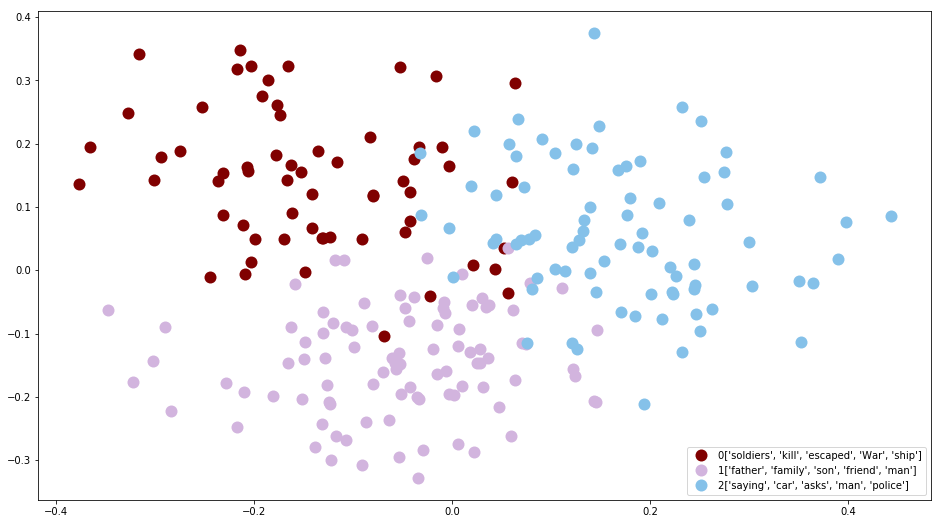

In [58]:
import matplotlib.pyplot as plt
%matplotlib inline 

# Set up the figure
figure, axis = plt.subplots(figsize=(16, 9))

groups = PCA.groupby(PCA.Cluster)
for cluster_ID, group in groups: # unpack group
    axis.plot(group.xCoordinate, group.yCoordinate, marker='o',  linestyle='', ms=12,
            label=str(cluster_ID) +  str(cluster_keywords_dict[cluster_ID]),  color=cluster_colors_dict[cluster_ID],
            mec='none')

# Show legend with only 1 point, position is right bottom.
axis.legend(numpoints=1,loc=4)  

# Show the plot
plt.show() 

In [59]:
plt.close()

<li> Indeed, cluster 2 and 3 are very very close.   
<li> Cluster 0 and cluster 1 cover a lost of movies.   
<li> But cluster 1's movies may not have a lot of shared similarities since they scattered all over the place.

## Step 5: Topic Modeling - Using Latent Dirichlet Allocation

### 5.1 The Basics

**What is topic modeling?** 
<li> a method for finding a group of words (i.e topic) from a collection of documents that best represents the information in the collection. 
<li> a form of text mining – a way to obtain recurring patterns of words in textual material.

**What is Latent Dirichlet Allocation?**   
Latent Dirichlet Allocation (LDA) model is a technique used to obtain topic models.

** How does Latent Dirichlet Allocation work?**

See this example:

Document 1: I had a peanut butter sandwich for breakfast.   
Document 2: I like to eat almonds, peanuts and walnuts.    
Document 3: My neighbor got a little dog yesterday.   
Document 4: Cats and dogs are mortal enemies.   
Document 5: You mustn’t feed peanuts to your dog.

LDA may produce the following results:   
Topic 1: 30% peanuts, 15% almonds, 10% breakfast… (this topic deals with food)    
Topic 2: 20% dogs, 10% cats, 5% peanuts… (this topic deals with pets or animals)   

Document 1: 100% Topic 1   
Document 2: 100% Topic 1   
Document 3: 100% Topic 2  
Document 4: 100% Topic 2  
Document 5: 70% Topic 1, 30% Topic 2

**How does LDA perform this process?**
1. Prepare the Document Term Matrix(DTM) - frequency of words in a particular document
![](1.png)   

2. Fit the LDA model with DTM (topic parameter is set to 2)   
*lda_model.fit(DTM)*

3. Transform the DTM   
*lda_model.transform(DTM)*

4. After transformation, we get two matrices from LDA   
4.1 lda_model.topic\_word_ saves the first matrix which has the shape of (2 topics * 28 words)   
Blank cells also have percentage numbers but those numbers are very small    
Highlighted red numbers denote that those words that convey the topic the best
![](2.png) 
4.2 lda_model.doc\_topic_ saves the second matrix which has the shape of (5 docs * 2 topics)
![](3.png) 

Once we know how it works, now we can use LDA on movie plots

Make a new copy of the dataframe,reset index, drop the 'cluster' column

In [60]:
df3 = df2.copy()
df3.index= range(238)
df3 = df3.drop('cluster', axis = 1)

<li> LDA model accepts an array-like or sparse matrix 
<li> It should be a Document Term Matrix(DTM)
<li> Its shape should (n_samples, n_features), so we cannot reuse the tfidfMatrix
<li> We need to rebuilt a DTM which also has moive plots as rows and all words as columns
<li> But the value would be the frequency of each word used in each movie plot

Build a new dict which has every word as keys and their positional column index as values   
e.g. {'abandon': 1,'abl': 2,'accept': 3,'accompani': 4, 'act': 5}

In [61]:
word_columnIndex_dict = {}
for x in range(len(all_words_from_tfidf)):
    word_columnIndex_dict[all_words_from_tfidf[x]] = x

In [62]:
# Inspect
word_columnIndex_dict

{'abandon': 0,
 'abl': 1,
 'accept': 2,
 'accompani': 3,
 'act': 4,
 'action': 5,
 'actual': 6,
 'address': 7,
 'admit': 8,
 'agre': 9,
 'aliv': 10,
 'allow': 11,
 'alon': 12,
 'alreadi': 13,
 'alway': 14,
 'angri': 15,
 'anoth': 16,
 'answer': 17,
 'anyon': 18,
 'anyth': 19,
 'apart': 20,
 'apolog': 21,
 'appar': 22,
 'appear': 23,
 'approach': 24,
 'area': 25,
 'arm': 26,
 'armi': 27,
 'arrang': 28,
 'arrest': 29,
 'arriv': 30,
 'ask': 31,
 'assist': 32,
 'attack': 33,
 'attempt': 34,
 'attend': 35,
 'attent': 36,
 'avoid': 37,
 'away': 38,
 'bad': 39,
 'bar': 40,
 'battl': 41,
 'beat': 42,
 'beauti': 43,
 'becom': 44,
 'bed': 45,
 'beg': 46,
 'begin': 47,
 'believ': 48,
 'best': 49,
 'better': 50,
 'big': 51,
 'black': 52,
 'blood': 53,
 'blow': 54,
 'board': 55,
 'bodi': 56,
 'book': 57,
 'box': 58,
 'boy': 59,
 'break': 60,
 'bring': 61,
 'broken': 62,
 'brother': 63,
 'brought': 64,
 'build': 65,
 'burn': 66,
 'busi': 67,
 'buy': 68,
 'ca': 69,
 'calm': 70,
 'captur': 71,
 'car':

In [63]:
plot_word_matrix = []
for plot in df3.MoviePlot:
    current_plot_word_freq = [0] * len(all_words_from_tfidf)
    current_plot_stemmed_words = tokenize_and_stem(plot)
    for word in current_plot_stemmed_words:
        if word in all_words_from_tfidf:
            current_plot_word_freq[word_columnIndex_dict[word]] += 1
    current_plot_word_freq = np.asarray(current_plot_word_freq)
    plot_word_matrix.append(current_plot_word_freq)
plot_word_matrix = np.asarray(plot_word_matrix)

In [64]:
# Inspect
plot_word_matrix
# Take the first number "2" for instance, it means word 'able' was in movie The Shawshank Redemption(1994) 2 times

array([[0, 2, 0, ..., 5, 0, 1],
       [0, 0, 2, ..., 5, 0, 4],
       [0, 0, 1, ..., 3, 0, 2],
       ..., 
       [0, 0, 0, ..., 0, 0, 4],
       [1, 1, 1, ..., 3, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

Now we use LDA on the matrix

In [65]:
import lda

# Build the model, we want  3 topics and iterate 500 times
model = lda.LDA(n_topics=3, n_iter=500, random_state=1)

# Fit the model with the matrix
model.fit(plot_word_matrix)


INFO:lda:n_documents: 238
INFO:lda:vocab_size: 510
INFO:lda:n_words: 98065
INFO:lda:n_topics: 3
INFO:lda:n_iter: 500
INFO:lda:<0> log likelihood: -707413
INFO:lda:<10> log likelihood: -674215
INFO:lda:<20> log likelihood: -655063
INFO:lda:<30> log likelihood: -649617
INFO:lda:<40> log likelihood: -646689
INFO:lda:<50> log likelihood: -643864
INFO:lda:<60> log likelihood: -642264
INFO:lda:<70> log likelihood: -640508
INFO:lda:<80> log likelihood: -639111
INFO:lda:<90> log likelihood: -637721
INFO:lda:<100> log likelihood: -636285
INFO:lda:<110> log likelihood: -634876
INFO:lda:<120> log likelihood: -634235
INFO:lda:<130> log likelihood: -633601
INFO:lda:<140> log likelihood: -632394
INFO:lda:<150> log likelihood: -632245
INFO:lda:<160> log likelihood: -631761
INFO:lda:<170> log likelihood: -631165
INFO:lda:<180> log likelihood: -631131
INFO:lda:<190> log likelihood: -630674
INFO:lda:<200> log likelihood: -630531
INFO:lda:<210> log likelihood: -630447
INFO:lda:<220> log likelihood: -6300

<li> "model.topic\_word\_" saves the importance of all words in each topic

In [66]:
topic_word_matrix = model.topic_word_ 

 <li> The shape of "model.topic\_word\_" is (3 topics * 510 keywords)

In [67]:
# There are 3 topics and 510 keywords
topic_word_matrix.shape

(3, 510)

<li> "model.doc\_topic\_" saves the importance of each plot in all topics

In [68]:
plot_topic_matrix = model.doc_topic_

<li> The shape of "model.doc\_topic\_" is (238 documents * 3 topics)

In [69]:
# There are 238 movie plot and 3 movie topics
plot_topic_matrix.shape

(238, 3)

### 5.2 Analyze LDA Result

<li> LDA does not have the same 'clusters.labels_.tolist()' function that KMeans has.   
<li> To see which movie is in which topic, we need to do the following:

**Where can we read that information? **   

From the 'plot_topic_matrix'   
Take moive plot 0 'The Shawshank Redemption(1994)' as an example:   
These five numbers denotes the this movie plot's topic coverage in five different topics

In [70]:
plot_topic_matrix[0] 

array([ 0.48534834,  0.18843392,  0.32621774])

So to get which movie towards most to which topic, we find the max value:

In [71]:
plot_topic_matrix[0].max()

0.48534834077236566

But we need to index of the actual topic :

In [72]:
plot_topic_matrix[0].argmax()  # 1 means movie 0 returns the highest probability on topic 1

0

Now we know, 'The Shawshank Redemption(1994)' is in topic 1

Do the above for all movies

Set up a dict that has this structure {topic_Id: [list of movie names]}

In [73]:
topic_movieName_dict = {}

for ith_row in range(len(plot_topic_matrix)):
    topic_ID = plot_topic_matrix[ith_row].argmax()
    if topic_ID not in topic_movieName_dict:
        topic_movieName_dict[topic_ID] = [df3.MovieName[ith_row]]
    else:
        topic_movieName_dict[topic_ID].append(df3.MovieName[ith_row])

In [74]:
# Inspect
topic_movieName_dict

{0: ['The Shawshank Redemption(1994)',
  'The Godfather(1972)',
  'The Godfather: Part II(1974)',
  '12 Angry Men(1957)',
  "Schindler's List(1993)",
  'Pulp Fiction(1994)',
  'Fight Club(1999)',
  'Forrest Gump(1994)',
  'Inception(2010)',
  "One Flew Over the Cuckoo's Nest(1975)",
  'Goodfellas(1990)',
  'City of God(2002)',
  'Se7en(1995)',
  "It's a Wonderful Life(1946)",
  'Life Is Beautiful(1997)',
  'Léon: The Professional(1994)',
  'Interstellar(2014)',
  'The Green Mile(1999)',
  'Psycho(1960)',
  'Casablanca(1942)',
  'City Lights(1931)',
  'The Intouchables(2011)',
  'The Pianist(2002)',
  'Whiplash(2014)',
  'Gladiator(2000)',
  'The Prestige(2006)',
  'Memento(2000)',
  'Sunset Blvd.(1950)',
  'Cinema Paradiso(1988)',
  'The Lives of Others(2006)',
  'Grave of the Fireflies(1988)',
  'American Beauty(1999)',
  'Blade Runner 2049(2017)',
  'Oldeuboi(2003)',
  'Witness for the Prosecution(1957)',
  'Once Upon a Time in America(1984)',
  'Dangal(2016)',
  'Citizen Kane(1941)'

For better visualization, we use a table to overview it

In [75]:
topic_movie_df = pd.DataFrame( [[k, v] for k, a in topic_movieName_dict.items() for v in a], columns=['Topic', 'MovieName'])

In [76]:
# Inspect
topic_movie_df[:5]

,Topic,MovieName
0,0,The Shawshank Redemption(1994)
1,0,The Godfather(1972)
2,0,The Godfather: Part II(1974)
3,0,12 Angry Men(1957)
4,0,Schindler's List(1993)


Join these two dfs on movie names

In [77]:
df4 = df3.merge(topic_movie_df,on = 'MovieName')

In [78]:
# Inspect
df4[:5]

,MovieId,Ranking,MovieName,MoviePlot,Topic
0,tt0111161,1,The Shawshank Redemption(1994),"In 1947, Andy Dufresne (Tim Robbins), a banker...",0
1,tt0068646,2,The Godfather(1972),"In late summer 1945, guests are gathered for t...",0
2,tt0071562,3,The Godfather: Part II(1974),The Godfather Part II presents two parallel st...,0
3,tt0468569,4,The Dark Knight(2008),The movie begins with a gang of men with clown...,1
4,tt0050083,5,12 Angry Men(1957),"In a New York City courthouse, an eighteen-yea...",0


In [79]:
# define a funtion to print top 5 keywords per topic ID
def print_topic_keywords(topic_ID):
    print ("Topic " + str(topic_ID)  + " top 5 keywords: " , end="") 
    
    topic_keywords_dict[topic_ID] = []
    top5_keywords_index = topic_word_matrix[topic_ID].argsort()[:-6:-1]
    for index in top5_keywords_index:
        stemmed_word = all_words_from_tfidf[index] 
        unstemmed_word = stemmed_unstemmed_dict[stemmed_word] 
        topic_keywords_dict[topic_ID].append(unstemmed_word)
   
    print (", ".join(topic_keywords_dict[topic_ID]))

In [80]:
# define a function to print all movies in that topic
def print_topic_movies(topic_ID):
    print ("Topic " + str(topic_ID) + " has " + str(len(topic_movieName_dict[topic_ID])) + " movies : " )
    print (', '.join(topic_movieName_dict[topic_ID]))  
    print ()

Print out topic info

In [81]:
print ("<Movie Clustering Result by LDA>")

topic_keywords_dict = {}

for topic_ID in range(len(topic_word_matrix)):
    print_topic_keywords(topic_ID)
    print_topic_movies(topic_ID)

<Movie Clustering Result by LDA>
Topic 0 top 5 keywords: day, man, home, father, night
Topic 0 has 153 movies : 
The Shawshank Redemption(1994), The Godfather(1972), The Godfather: Part II(1974), 12 Angry Men(1957), Schindler's List(1993), Pulp Fiction(1994), Fight Club(1999), Forrest Gump(1994), Inception(2010), One Flew Over the Cuckoo's Nest(1975), Goodfellas(1990), City of God(2002), Se7en(1995), It's a Wonderful Life(1946), Life Is Beautiful(1997), Léon: The Professional(1994), Interstellar(2014), The Green Mile(1999), Psycho(1960), Casablanca(1942), City Lights(1931), The Intouchables(2011), The Pianist(2002), Whiplash(2014), Gladiator(2000), The Prestige(2006), Memento(2000), Sunset Blvd.(1950), Cinema Paradiso(1988), The Lives of Others(2006), Grave of the Fireflies(1988), American Beauty(1999), Blade Runner 2049(2017), Oldeuboi(2003), Witness for the Prosecution(1957), Once Upon a Time in America(1984), Dangal(2016), Citizen Kane(1941), Vertigo(1958), Braveheart(1995), M(1931)